# 1000 Genomes data analysis

## Finding trios

First we need to download the 1000 genomes data; we will use the q-arm of chromosome 20. Trees have already been inferred for this data and are available from [Zenodo](https://zenodo.org/record/5495535):


In [283]:
import urllib.request
#urllib.request.urlretrieve("https://zenodo.org/record/5495535/files/hgdp_tgp_sgdp_chr20_q.dated.trees.tsz?download=1",
#                           "data/hgdp_tgp_sgdp_chr20_q.dated.trees.tsz")

I ran `tsunzip data/hgdp_tgp_sgdp_chr20_q.dated.trees.tsz` to unzip, such that we can load the data


In [284]:
import tskit
import numpy as np
import pandas as pd

ts = tskit.load("data/hgdp_tgp_sgdp_chr20_q.dated.trees")
ts


We need to find a trio and randomly sample three individuals. I have the acession numbers for the trio, so we just need a table with nodes and accession ids

In [285]:
import json

meta = ts.individual(0).metadata
print(json.loads(meta))
print(json.loads(meta)['sample'])
str(meta)

{'array_non_reference_discordance': '0.111741', 'capmq': '29', 'coverage': '29.71', 'freemix': '0.00137', 'insert_size_average': '500.1', 'library': 'HGDP01201.11144852', 'library_type': 'PCR', 'region': 'AFRICA', 'sample': 'HGDP01201', 'sample_accession': 'ERS474141', 'sex': 'F', 'source': 'sanger'}
HGDP01201


'b\'{"array_non_reference_discordance": "0.111741", "capmq": "29", "coverage": "29.71", "freemix": "0.00137", "insert_size_average": "500.1", "library": "HGDP01201.11144852", "library_type": "PCR", "region": "AFRICA", "sample": "HGDP01201", "sample_accession": "ERS474141", "sex": "F", "source": "sanger"}\''

That works fine, but some of the samples don't have accession ids:

In [286]:
meta2 = ts.individual(3752).metadata
print(json.loads(meta2))
print(json.loads(meta)['sample'])

{'aliases': 'zapo0098', 'contributor': 'William Klitz / Cheryl Winkler', 'country': 'Mexico', 'dna_source': 'Genomic_from_cell_lines', 'embargo': 'FullyPublic', 'gender': 'M', 'illumina_id': 'LP6005443-DNA_A12', 'region': 'America', 'sample_id': 'zapo0098', 'sequencing_panel': 'C', 'sgdp_id': 'S_Zapotec-1', 'town': 'San Juan Guelavia'}
HGDP01201


So we need to figure out the metadata structure for this data

In [287]:
ts.table_metadata_schemas

TableMetadataSchemas(node=, edge=, site=, mutation=, migration=, individual=, population=)

That's not helpful. Maybe it would be easier to just do regexp on the raw JSON data. Let's figure it out for one sample

In [288]:
import re
bool(re.search("ERS474141", str(meta)))

True

In [289]:
meta

b'{"array_non_reference_discordance": "0.111741", "capmq": "29", "coverage": "29.71", "freemix": "0.00137", "insert_size_average": "500.1", "library": "HGDP01201.11144852", "library_type": "PCR", "region": "AFRICA", "sample": "HGDP01201", "sample_accession": "ERS474141", "sex": "F", "source": "sanger"}'

In [290]:
print(bool(re.search("HGDP01201|dfsdf", str(meta))))
print(bool(re.search("HGDP01202", str(meta))))

True
False


 We can get the Accession IDs for one trio from [this article](https://wikis.utexas.edu/display/bioiteam/Human+Trios+--+GVA2020). Now let's search

In [291]:
trio_ceu = "NA12892|NA12891|NA12878"

d = []
for i in ts.individuals():
    if bool(re.search(trio_ceu, str(i.metadata))):
        d.append(i.id)
d

[2711]

In [292]:
ts.individual(2711)

Individual(id=2711, flags=0, location=array([], dtype=float64), parents=array([], dtype=int32), nodes=array([5422, 5423], dtype=int32), metadata=b'{"family_id": "1463", "gender": "2", "individual_id": "NA12878", "maternal_id": "NA12892", "other_comments": null, "paternal_id": "NA12891", "phenotype": null, "relationship": "mother; child", "second_order": null, "siblings": null, "third_order": null}')

Well this is peculiar. We only seem to have the proband, not the parents! I found [this list](https://genome.ucsc.edu/cgi-bin/hgTrackUi?db=hg38&g=tgpTrios) of all the trios in 1000 Genomes, so let's check them.

In [293]:
trios_ls = [
    ["NA12892", "NA12891", "NA12878"],
    ["NA19678", "NA19675", "NA19679"],
    ["NA19660", "NA19685", "NA19661"],
    ["HG00732", "HG00733", "HG00731"],
    ["HG00657", "HG00702", "HG00656"],
    ["HG02025", "HG02024", "HG02026"],
    ["NA19238", "NA19240", "NA19239"]
] 

def find_nodes(search_str):
    d = []
    for i in ts.individuals():
        if bool(re.search(search_str, str(i.metadata))):
            d.append(str(i.id))
    return ", ".join(d)


trios_df = pd.DataFrame(trios_ls, columns=["mother","child","father"])
trios_df["search_str"]= trios_df.apply(lambda x: '|'.join(x.values.tolist()), axis=1)
trios_df["search_results"] = trios_df["search_str"].apply(lambda x: find_nodes(x))
trios_df


,mother,child,father,search_str,search_results
0,NA12892,NA12891,NA12878,NA12892|NA12891|NA12878,2711
1,NA19678,NA19675,NA19679,NA19678|NA19675|NA19679,"3150, 3151"
2,NA19660,NA19685,NA19661,NA19660|NA19685|NA19661,"3144, 3146"
3,HG00732,HG00733,HG00731,HG00732|HG00733|HG00731,"1238, 1239"
4,HG00657,HG00702,HG00656,HG00657|HG00702|HG00656,"1214, 1215"
5,HG02025,HG02024,HG02026,HG02025|HG02024|HG02026,"1691, 1692"
6,NA19238,NA19240,NA19239,NA19238|NA19240|NA19239,"3045, 3046"


In [294]:
print(json.loads(ts.individual(3150).metadata))
print(json.loads(ts.individual(3151).metadata))

{'family_id': 'm009', 'gender': '2', 'individual_id': 'NA19678', 'maternal_id': None, 'other_comments': None, 'paternal_id': None, 'phenotype': None, 'relationship': 'mother', 'second_order': 'NA19677', 'siblings': None, 'third_order': None}
{'family_id': 'm009', 'gender': '1', 'individual_id': 'NA19679', 'maternal_id': None, 'other_comments': None, 'paternal_id': None, 'phenotype': None, 'relationship': 'father', 'second_order': 'NA19677', 'siblings': None, 'third_order': None}


So for all the other trios besides the first (which is the CEU trio), only the parents are in the TS, not the child. I'm guessing this we usually exclude related individuals when calculating allele frequencies or conducting a GWAS. It seems like this dataset isn't helpful for our purposes.

## Visualisation experiments

Let's try visualising these trees. To start with, we will work with a simplified tree with 20 nodes from 10 random individuals 

In [295]:
import random
random.seed(2023)
n_individuals = 6

individuals_sample = random.sample(range(ts.num_individuals-1),n_individuals)
ls = []
for m in individuals_sample:
    ls.append(ts.individual(m).nodes)
nodes_sample = np.concatenate(ls)
nodes_sample

array([3136, 3137, 5746, 5747, 3658, 3659, 6912, 6913, 3188, 3189, 2622,
       2623], dtype=int32)

In [296]:
ts_small = ts.simplify(nodes_sample)
ts_small

Let's start by plotting a random subtree

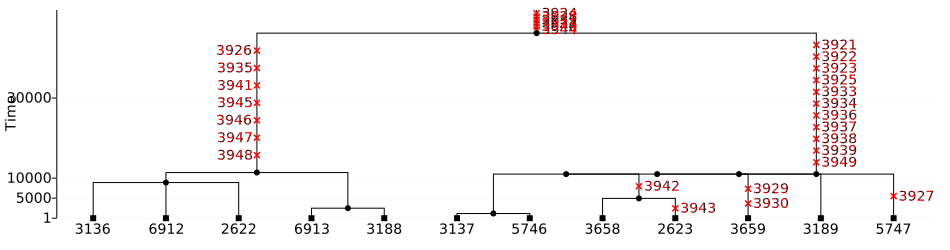

In [297]:
test_ts = ts_small.at_index(200)
wide_fmt = (950, 250)

labels = {}
for n in test_ts.nodes():
    if n in range(20):
        labels[n] = nodes_sample[n]

test_ts.draw_svg(
    size=wide_fmt,
    y_gridlines=True,
    y_axis=True,
    y_ticks=[1, 10000, 5000, 30000, 60000],
    node_labels=labels
)

Now let's plot a short sequence of trees in a certain region

In [298]:
ts_small.at_index(202)

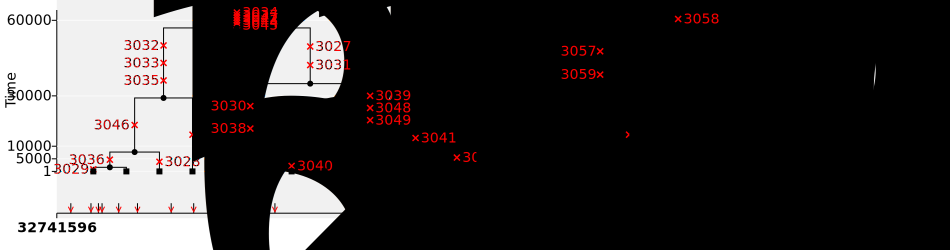

In [299]:
x_limits = [32741596,32749314]

node_label_style = (
    ".node > .lab {font-size: 80%}"
    ".leaf > .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
)

ts_small.draw_svg(
    y_gridlines=True,
    size=wide_fmt,
    x_lim=x_limits,
    y_axis=True,
    y_ticks=[1, 10000, 5000, 30000, 60000],
    node_labels=labels,
    style=node_label_style
)

### Closest relative span-wise

#### Testing the code

Using Yan Wong's code [from this issue on GitHub](https://github.com/duncanMR/pedigrees_project/issues/1) we can visualise the average span of the genome in which two samples are in the same subtree. Let's use a trivial example first to understand exactly what it's doing

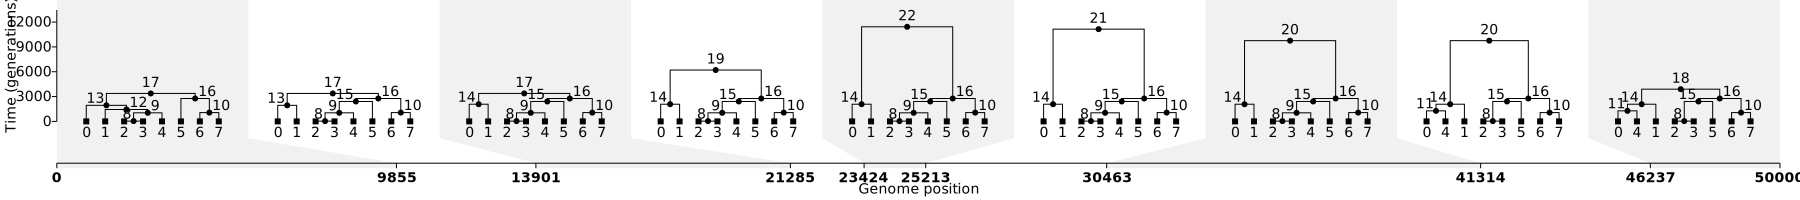

In [300]:
ts2 = tskit.load("data/viz_ts_small.trees")

x_limits = [5000, 15000]
# Create evenly-spaced y tick positions to avoid overlap
y_tick_pos = [0, 3000, 6000, 9000, 12000]

ts2.draw_svg(y_axis=True, y_ticks=y_tick_pos)

In [304]:
sample_span = np.zeros((ts2.num_samples, ts2.num_samples))

for tree in ts2.simplify().trees(sample_lists=True):
    #print(f"Visiting tree {tree.index}")
    if tree.has_single_root:
        for u in ts2.samples():
            #print(f"  Checking neighbours for sample {u} under parent {tree.parent(u)}")
            for nearest in tree.samples(tree.parent(u)):
                if nearest != u:
                    #print(f"    {nearest} is a neighbour of {u}")
                    #print(f"    Adding {tree.span} to the sample span between {u} and {nearest}")
                    sample_span[u, nearest] += tree.span
sample_span = sample_span / ts2.sequence_length
sample_span

array([[0.     , 0.82628, 0.1971 , 0.1971 , 0.37082, 0.     , 0.     ,
        0.     ],
       [0.8029 , 0.     , 0.1971 , 0.1971 , 0.37082, 0.     , 0.     ,
        0.     ],
       [0.     , 0.     , 0.     , 1.     , 0.     , 0.     , 0.     ,
        0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     , 0.     ,
        0.     ],
       [0.17372, 0.     , 0.82628, 0.82628, 0.     , 0.     , 0.     ,
        0.     ],
       [0.     , 0.     , 0.8029 , 0.8029 , 0.62918, 0.     , 0.1971 ,
        0.1971 ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        1.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 1.     ,
        0.     ]])

In [305]:
n = 3

samples = [str(s) for s in ts2.samples()]
span_df = pd.DataFrame(sample_span.T, columns = samples)
span_df['sample'] = samples
span_melted = span_df.melt(id_vars=['sample'])
span_melted.set_index('sample',drop=True, inplace=True)
topn = span_melted.groupby('variable')['value'].nlargest(n).reset_index()
topn.columns = ['Sample','Neighbour','Value']
topn['Norm_Value'] = topn['Value']/ topn.groupby('Sample')['Value'].transform('sum')
topn = topn.sort_values(['Sample', 'Norm_Value'], ascending=True)
topn


,Sample,Neighbour,Value,Norm_Value
2,0,2,0.19710,0.141371
1,0,4,0.37082,0.265973
0,0,1,0.82628,0.592655
5,1,2,0.19710,0.143783
4,1,4,0.37082,0.270510
3,1,0,0.80290,0.585708
7,2,0,0.00000,0.000000
8,2,1,0.00000,0.000000
6,2,3,1.00000,1.000000
10,3,0,0.00000,0.000000


In [306]:
neighbours = topn['Neighbour'].drop_duplicates().to_list()
neighbours.sort()
neighbours

['0', '1', '2', '3', '4', '6', '7']

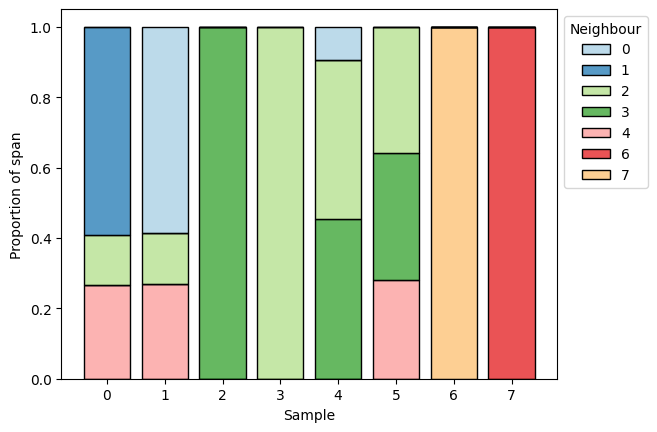

In [307]:
ax = sns.histplot(topn, x='Sample', hue='Neighbour', weights='Norm_Value',
                  multiple='stack', shrink=0.8, hue_order = neighbours, palette="Paired")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='Sample', ylabel='Proportion of span')

plt.show()

Now let's write this as a general function

In [308]:

def make_span_df(ts, n_per_sample):
    sample_span = np.zeros((ts.num_samples, ts.num_samples))

    for tree in ts.simplify().trees(sample_lists=True):
        if tree.has_single_root:
            for u in ts.samples():
                for nearest in tree.samples(tree.parent(u)):
                    if nearest != u:
                        sample_span[u, nearest] += tree.span
    sample_span = sample_span / ts.sequence_length
    samples = [str(s) for s in ts.samples()]
    
    #Construct the dataframe
    span_df = pd.DataFrame(sample_span.T, columns = samples)
    span_df['sample'] = samples
    
    #Melt the dataframe for plotting
    span_melted = span_df.melt(id_vars=['sample'])
    span_melted.set_index('sample',drop=True, inplace=True)
    topn = span_melted.groupby('variable')['value'].nlargest(n_per_sample).reset_index()
    topn.columns = ['Sample','Neighbour','Value']
    #Normalise spans so that the bars are of the same height
    topn['Norm_Value'] = topn['Value']/ topn.groupby('Sample')['Value'].transform('sum')
    topn.sort_values(by='Sample', inplace=True, key=lambda x : x.astype(int))
    return topn

def plot_span_df(df, palette):
    #neighbours_list ordered for plotting
    neighbours = df['Neighbour'].drop_duplicates().to_list()
    neighbours.sort(key = int)
    
    #using histplot because it can create stacked bar charts nicely
    ax = sns.histplot(df, x='Sample', hue='Neighbour', weights='Norm_Value',
                  multiple='stack', shrink=0.8, hue_order = neighbours, palette=palette)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(xlabel='Sample', ylabel='Proportion of span')

    plt.show()
    

#### Applying code to real data

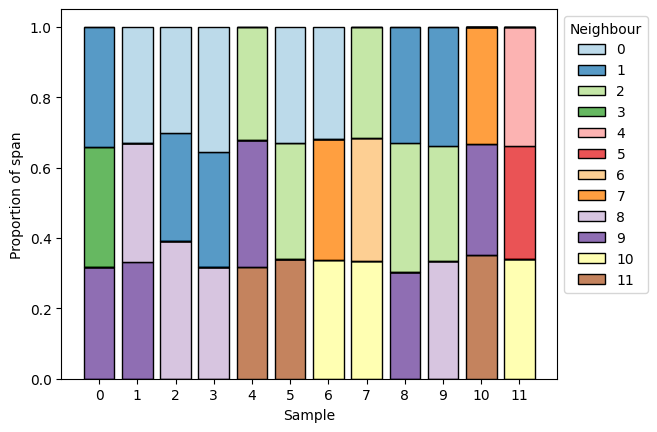

In [309]:
span_df = make_span_df(ts_small, 3)
plot_span_df(span_df, "Paired")


Since the individuals are presumably unrelated, no sample is particularly close to any other sample for a large span of the genome.